## Flood Impact Prediction (FIP) Assessment
The description would be updated...

In [6]:
import os
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from shapely.geometry import Point
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, QuantileTransformer
import matplotlib.pyplot as plt
from functools import reduce
import fhv
pd.options.mode.chained_assignment = None

### Load basic data

In [19]:
# Union ID list (5160)
uidList = pd.read_hdf('./data/uidlist.hdf')
# Flatten cell indices for Union ID
uidx = np.load('./data/uidx.npz', allow_pickle=True)['uidx']
# Shapefiles of administrative units
shp_district = gpd.read_file('./data/adm_district.shp')
shp_upazila = gpd.read_file('./data/adm_upazila.shp')
shp_union = gpd.read_file('./data/adm_union.shp')

### Number of people affected by 2017 flood
The affected people is assessed by counting population per pixel (PPP) in the flooded areas.

In [160]:
# Load data
inun = rasterio.open('./data/bgd_inun_30m.tif').read(1).flatten()   # 1 (Perennial waterbodies), 2 (Flood inundation area)
popu = rasterio.open('./data/bgd_ppp_2017_30m_decuple.tif').read(1).flatten()
fcst = rasterio.open('./data/flood2017forecast_30m_aug16_ffwc_decuple.tif').read(1)  # Flood depth (decuple)
fcst = np.array(fcst >= 20).astype(np.int8).flatten()

# Affected population per union
popuInun = popu.copy()
popuInun[inun == 0] = 0       # Population in both Perennial water and Flood inundation
popuInun[inun != 2] = 0       # Population in Flood inundation
popuInun = popuInun.flatten()
popuFcst = popu.copy()
popuFcst[fcst == 0] = 0       # Population in Flood depth (>= 1.0m)

# Counting population
totlPopu = np.zeros(uidList.shape)
afftPopuInun = np.zeros_like(totlPopu)
afftPopuFcst = np.zeros_like(totlPopu)
totlCell = [len(udx) for udx in uidx]
afftCellInun = np.zeros_like(totlPopu)
afftCellFcst = np.zeros_like(totlPopu)
for i, uid in uidList.iteritems():
    totlPopu[i] = popu[uidx[i]].sum()
    afftPopuInun[i] = popuInun[uidx[i]].sum()
    afftPopuFcst[i] = popuFcst[uidx[i]].sum()
    afftCellInun[i] = np.isin(inun[uidx[i]], [1,2]).sum()
    afftCellFcst[i] = np.isin(fcst[uidx[i]], [1]).sum()
# Rescale and Add one to avoid numeric errors
totlPopu = (totlPopu+1)/10
afftPopuInun /= 10
afftPopuFcst /= 10

In [161]:
# Generate a Union dataframe
impact4 = shp_union.drop('geometry', axis=1)
impact4['POPU_TOTAL'], impact4['POPU_INUN'], impact4['POPU_FCST'] = totlPopu, afftPopuInun, afftPopuFcst
impact4['POPU_INUN_RATIO'] = afftPopuInun/totlPopu
impact4['POPU_FCST_RATIO'] = afftPopuFcst/totlPopu
impact4['CELL_TOTAL'], impact4['CELL_INUN'], impact4['CELL_FCST'] = totlCell, afftCellInun, afftCellFcst
impact4['CELL_INUN_RATIO'] = afftCellInun/totlCell
impact4['CELL_FCST_RATIO'] = afftCellFcst/totlCell
# Aggregate to Upazila level
varlist = ['POPU_TOTAL','POPU_INUN','POPU_FCST','CELL_TOTAL','CELL_INUN','CELL_FCST']
impact3 = impact4.groupby(['ADM3_PCODE', 'ADM3_EN'])[varlist].sum()
impact3['POPU_INUN_RATIO'] = impact3['POPU_INUN']/impact3['POPU_TOTAL']
impact3['POPU_FCST_RATIO'] = impact3['POPU_FCST']/impact3['POPU_TOTAL']
impact3['CELL_INUN_RATIO'] = impact3['CELL_INUN']/impact3['CELL_TOTAL']
impact3['CELL_FCST_RATIO'] = impact3['CELL_FCST']/impact3['CELL_TOTAL']
impact3['ADM2_PCODE'], impact3['ADM2_EN'] = shp_upazila['ADM2_PCODE'].values, shp_upazila['ADM2_EN'].values
# Aggregate to District level
impact2 = impact3.groupby(['ADM2_PCODE', 'ADM2_EN'])[varlist].sum()
impact2['POPU_INUN_RATIO'] = impact2['POPU_INUN']/impact2['POPU_TOTAL']
impact2['POPU_FCST_RATIO'] = impact2['POPU_FCST']/impact2['POPU_TOTAL']
impact2['CELL_INUN_RATIO'] = impact2['CELL_INUN']/impact2['CELL_TOTAL']
impact2['CELL_FCST_RATIO'] = impact2['CELL_FCST']/impact2['CELL_TOTAL']
impact2['ADM1_PCODE'], impact2['ADM1_EN'] = shp_district['ADM1_PCODE'].values, shp_district['ADM1_EN'].values

# Print
print('TOTAL_POPU_INUN: {:,}'.format(impact4['POPU_INUN'].sum().astype(int)))
print('TOTAL_POPU_FCST: {:,}'.format(impact4['POPU_FCST'].sum().astype(int)))

# Merge with shapefiles
varlist.extend(['POPU_INUN_RATIO', 'POPU_FCST_RATIO', 'CELL_INUN_RATIO', 'CELL_FCST_RATIO'])
map_union = shp_union.merge(impact4, on='ADM4_PCODE')
map_upazila = shp_upazila.merge(impact3[varlist], on='ADM3_PCODE')
map_district = shp_district.merge(impact2[varlist], on='ADM2_PCODE')

TOTAL_POPU_INUN: 19,642,620
TOTAL_POPU_FCST: 26,773,933


### Initialize mapping parameters

In [162]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from pyproj import Proj, transform    # In case of re-projection
lims = [88.00, 92.7, 20.57, 26.64]    # [xmin, xmax, ymin, ymax]

# Colarmap and Colorbar controller
def cbarpam(bounds, color, labloc='on', boundaries=None, extension=None):
    '''Returns parameters for colormap and colorbar objects with a specified style.

        Parameters
        ----------
        bounds: list of bounds
        color: name of colormap or list of color names

        labloc: 'on' or 'in'
        boundaries: 
        extension: 'both', 'min', 'max'

        Return
        ------
        cmap: colormap
        norm: nomalization
        vmin: vmin for plotting
        vmax: vmax for plotting
        boundaries: boundaries for plotting
    '''
    
    gradient = np.linspace(0, 1, len(bounds)+1)
    # Create colorlist
    if type(color) is list:
        cmap = colors.ListedColormap(color,"")
    elif type(color) is str:
        cmap = plt.get_cmap(color, len(gradient))    
        # Extension
        colorsList = list(cmap(np.arange(len(gradient))))
        if extension is 'both':
            cmap = colors.ListedColormap(colorsList[1:-1],"")
            cmap.set_under(colorsList[0])
            cmap.set_over(colorsList[-1])
        elif extension is 'max':
            cmap = colors.ListedColormap(colorsList[:-1],"")
            cmap.set_over(colorsList[-1])
        elif extension is 'min':
            cmap = colors.ListedColormap(colorsList[1:],"")
            cmap.set_under(colorsList[0])
        elif extension is None:
            gradient = np.linspace(0, 1, len(bounds)-1)
            cmap = plt.get_cmap(color, len(gradient))
        else:
            raise ValueError('Check the extension')
    else:
        raise ValueError('Check the type of color.')
    # Normalization
    norm = colors.BoundaryNorm(bounds, cmap.N)
    # vmin and vmax
    vmin=bounds[0]
    vmax=bounds[-1]
    # Ticks
    if labloc == 'on':
        ticks = bounds
    elif labloc == 'in':
        ticks = np.array(bounds)[0:-1] + (np.array(bounds)[1:] - np.array(bounds)[0:-1])/2
    
    return cmap, norm, vmin, vmax, ticks, boundaries

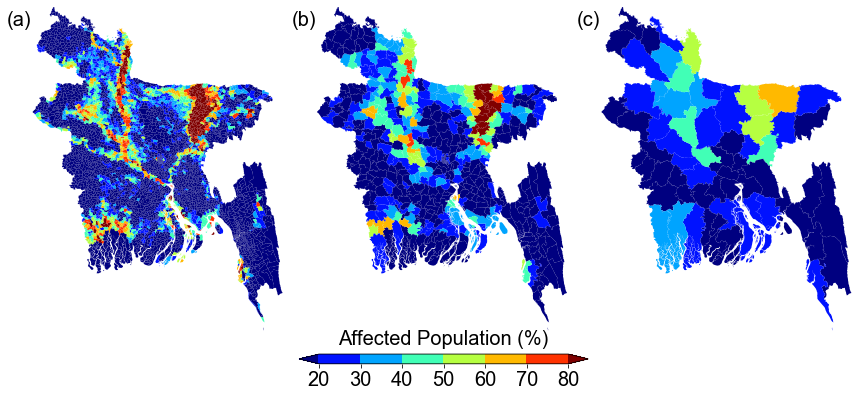

In [165]:
# Mapping
# sns.set_style("white", {'axes.linewidth': 1, 'grid.color': 'black'})

# Colormap
bounds = list(np.arange(0.2,0.8,0.1))
boundaries = [0]+bounds+[1]
cmap, norm, vmin, vmax, ticks, boundaries = cbarpam(bounds, 'jet', labloc='on',
                                                    boundaries=boundaries, extension='both')

# Plotting
fignumb = ['(a)', '(b)', '(c)']
figlabel = 'Affected Population (%)'
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(12,5), facecolor='w')
for (i, el) in enumerate([map_union, map_upazila, map_district]):
    ax = axes.flatten('F')[i]
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.axis(lims)
    el.plot(ax=ax, column='CELL_INUN_RATIO', 
            cmap=cmap, norm=norm, vmin=vmin, vmax=vmax)
    ax.annotate(fignumb[i], xy=(-0.05, 0.96), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center',
                fontname='arial',fontsize=20)    
plt.tight_layout()
# Colorbar
cax = inset_axes(ax, width="46%", height="3%",
                 loc='lower left',
                 bbox_to_anchor=(-1.2, -0.1, 2.5, 1),
                 bbox_transform=ax.transAxes,borderpad=0)
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm,
                                 boundaries=boundaries,
                                 extend='both',
                                 extendfrac=0.08,
                                 ticks = ticks,
                                 spacing='uniform',
                                 orientation='horizontal')
cbar.ax.set_xticklabels(['%d'%lb for lb in np.array(bounds)*100], 
                        fontname='arial', fontsize=20)
cbar.set_label(figlabel, labelpad=-60, 
               fontname='arial', fontsize=20, 
               horizontalalignment='center')
plt.show()

### Load datasets

In [116]:
# Load complete datasets
variable_name = pd.read_hdf('./data/variable_table.hdf')
variable = np.load('./data/variable.npy')
ncell = variable.shape[0]
# Load District ID
with rasterio.open(os.path.join('data', 'distid_peru.tif')) as src:
    did = src.read().squeeze()
    meta = src.meta.copy()
valid = did > 0
valid_id = did[did >0]
# Flood Inundation
with rasterio.open('./data/inundation_peru.tif') as src:
    fdep = src.read(1)
# Load population
# LandScan 2017: 30,555,036
# INEI 2017: 31,237,385
with rasterio.open('./data/population_peru.tif') as src:
    popu = src.read(1)
popu[(popu == -2147483647) | (popu < 0)] = 0    
popu = popu/popu.sum()*31237385                 
popu = popu.round()
npopu = popu.sum()                              # 31,177,745
# GDP(PPP) per grid (standard GDP * HYDE population)
# WorldBank's 2015 GDP(PPP): $369.342 billion (constant 2011 international $)
# WorldBank's 2015 GDP(PPP) per capita: $12,121 (constant 2011 international $)
with rasterio.open('./data/gdp_peru.tif') as src:
    gdp = src.read(1)
gdp[gdp == -9] = 0
gdp = gdp/gdp.sum()*369.342*10**9
# Hospitals and Travel-time to Health facilities
hospital = gpd.read_file('data/health_facility_MINSA_all.shp')
# - Flood inundation depth for hospitals
hospital = hospital[hospital.x != 0]
hospital['geometry'] = hospital['geometry'].to_crs(epsg=32717)
coords = [(x,y) for x,y in zip(hospital.geometry.x, hospital.geometry.y)]
with rasterio.open('./data/inundation_peru.tif') as src:
    hospital['fdep'] = [x[0] for x in src.sample(coords)]    # Inundation value
# - Travel-time to health facilities
ttime_nf = rasterio.open('./data/traveltime/health_noflood.tif').read(1)
ttime_yf = rasterio.open('./data/traveltime/health_yesflood.tif').read(1)
ttime_nf[np.isin(ttime_nf, [-32768, -1])] = 0
ttime_yf[np.isin(ttime_yf, [-32768, -1])] = 0
att = np.abs(ttime_yf - ttime_nf)

### FHV Assessment - Custom weight


In [32]:
# Custom weights
cwgt = pd.read_excel('./data/variable_weight_custom.xlsx')
cwgt = cwgt[['Name','Weight']] 
cwgt.drop(cwgt.tail(1).index,inplace=True)
cwgt = variable_name.merge(cwgt,on='Name').Weight.values
# Customized Vulnerability
vuln_custom = np.dot(variable,cwgt)
vuln_custom = fhv.ValidCellToMap(vuln_custom, valid, dtype='float32', nodata=-9999)
# Saving as GeoTiff
if True:
    fhv.GenerateRaster('./data/vulnability_custom.tif', meta, vuln_custom, 
                       new_dtype=rasterio.float32, new_nodata=-9999)

./data/vulnability_custom.tif is saved.


### FHV Assessment - Random weight

In [114]:
# Sensitivity analysis with random weights
nt = 1000      # Must be a multiple of 100
thsd = 0.55
freq = np.zeros([variable.shape[0],1])
for i in range(nt//100):
    rwgt = np.random.random([variable.shape[1],100])
    rwgt = rwgt/rwgt.sum(axis=0)
    score = np.dot(variable,rwgt)
    freq += (score > thsd).sum(1)[:,None]
vuln_random = freq/nt
vuln_random = fhv.ValidCellToMap(vuln_random.squeeze(), valid, dtype='float32', nodata=-9999)
# Temporarily
vuln_random[vuln_random < 0.7] = -9999
vulnRand = vuln_random.copy()
vulnRand[vulnRand>=0.7] = 1
vulnRand[vulnRand<0.7] = 0
vulnRand = vulnRand.astype('int8')
# Saving as GeoTiff
if True:
    fhv.GenerateRaster('./data/vulnability_random.tif', meta, vuln_random, 
                       new_dtype=rasterio.float32, new_nodata=-9999)
    fhv.GenerateRaster('./data/vulnability_random_logit.tif', meta, vulnRand, 
                       new_dtype=rasterio.int8, new_nodata=0)

./data/vulnability_random.tif is saved.
./data/vulnability_random_logit.tif is saved.


### Impact Assessment

In [120]:
# Impact Assessment
# (1) Affected popoulation
# *Affected population is assumed to increase linearly with water level until 2 meters.
thsd = 10
ratio = fdep.copy()
ratio[ratio <= thsd] = ratio[ratio <= thsd]/thsd
ratio[ratio > thsd] = 1
popuAfft = np.sum(ratio*popu)
# (2) Affected GDP
# *Affected GDP is assumed to increase linearly with water level from a damage of zero 
# for a water level of zero, to a maximum affected GDP at a water level of 3 meter.
thsd = 30
ratio = fdep.copy()
ratio[ratio <= thsd] = ratio[ratio <= thsd]/thsd
ratio[ratio > thsd] = 1
gdpAfft = np.sum(ratio*gdp)
# (3) Population in FHV zones
popuFHV = popu[vuln_custom >= 0.6].sum()
# (4) Populaion in PDV zone
popuPDV = popu[vuln_random >= 0.7].sum()
# (5) Affected Hospitals
# *If flood depth is over 1 meter
thsd = 10
nhsp = hospital.shape[0]
hspAfft = (hospital.fdep > 10).sum()
# Population with low accessibility
# *If Addtional Travel Time (ATT) is over 
thsd = 3*60
attAfft = popu[att > thsd].sum()
# Print the results of the Impacts Assessment
print('==================================================')
print('Impact Assessment')
print('--------------------------------------------------')
print('Affected population:\t{:>10,d} ({:.1f}%)'.format(int(popuAfft), popuAfft/npopu*100))
print('Affected GDP(PPP):\t${:>7,.0f}'.format(gdpAfft))
print('Population in FHV:\t{:>10,d} ({:.1f}%)'.format(int(popuFHV), popuFHV/npopu*100))
print('Area of FHV:\t{:.2f}%'.format((vuln_custom>=0.6).sum()/ncell*100))
print('Population in PVZ:\t{:>10,d} ({:.1f}%)'.format(int(popuPDV), popuPDV/npopu*100))
print('Area of PVZ:\t{:.2f}%'.format((vuln_random>=0.7).sum()/ncell*100))
print('Damaged Hospitals:\t{:6d}/{:3d} ({:.1f}%)'.format(int(hspAfft), nhsp, hspAfft/nhsp*100))
print('Low accessibility:\t{:>10,d} ({:.1f}%)'.format(int(attAfft), attAfft/npopu*100))
print('==================================================')

# print('PdomHzon area-A:\t{:.2f}%'.format(pdomHzonAreaA))
# print('PdomHzon area-B:\t{:.2f}%'.format(pdomHzonAreaB))
# print('Popu in pdomHzon-A:\t{:>10,d} ({:.1f}%)'.format(int(pdomHzonPopuA), pdomHzonPopuA/popuTotl*100))
# print('Popu in pdomHzon-B:\t{:>10,d} ({:.1f}%)'.format(int(pdomHzonPopuB), pdomHzonPopuB/popuTotl*100))
# print('Hzon in pdomHzon-A:\t{:.2f}%'.format(hzonInPdomA*100))
# print('Hzon in pdomHzon-B:\t{:.2f}%'.format(hzonInPdomB*100))
# print('Affected GDP:\t\t${:>7,.1f} B'.format(gdpAfft/10**9))
# print('Affected GDP per capita:${:>7,.1f} ({:.1f}%)'.format(gdpAfft/popuTotl, (gdpAfft/popuTotl)/(gdp.sum()/popuTotl)*100))
# print('*GDP(PPP) per capita:\t${:>7,d}'.format(int(gdp.sum()/popuTotl)))
# print('*Total population:     {:>,d}'.format(int(popuTotl)))
# print('--------------------------------------------------')
# print('Health Risk Assessment')
# print('--------------------------------------------------')
# print('Affected PHC:\t\t{:5d}/{:3d} ({:.1f}%)'.format(int(phcAfft), nphc, phcAfft/nphc*100))
# print('Affected Hospitals:\t{:6d}/{:3d} ({:.1f}%)'.format(int(hspAfft), nhsp, hspAfft/nhsp*100))
# print('ATT(>1hr) to PHC:\t{:>10,d} ({:.1f}%)'.format(int(popuAttPhc), popuAttPhc/popuTotl*100))
# print('ATT(>1hr) to Hospital:\t{:>10,d} ({:.1f}%)'.format(int(popuAttHsp), popuAttHsp/popuTotl*100))
# print('==================================================')

Impact Assessment
--------------------------------------------------
Affected population:	 1,047,864 (3.4%)
Affected GDP(PPP):	$1,428,493,508
Population in FHV:	   190,891 (0.6%)
Area of FHV:	1.90%
Population in PVZ:	   146,737 (0.5%)
Area of PVZ:	5.57%
Damaged Hospitals:	   250/8042 (3.1%)
Low accessibility:	   218,492 (0.7%)


0.01897337872694876

In [ ]:

# # Mapping
# import matplotlib.pyplot as plt
# from matplotlib.patches import Patch
# from matplotlib.colors import ListedColormap
# import matplotlib.colors as colors
# from rasterio.plot import plotting_extent
# # from pyproj import Proj, transform    # In case of re-projection
# import seaborn as sns
# sns.set(font_scale=1.5, style="white")
# # Adiministrative boundary
# peru_admin0 = gpd.read_file('./data/per_admbnda_adm0_2018.shp')
# peru_admin0 = peru_admin0.to_crs({'init':'epsg:32717'})
# lims = [-9086003.265, -7611331.177, -2103824.411, 31907.578]
# # Define the colors you want
# cmap = ListedColormap(["white", "tan", "springgreen", "darkgreen"])

# # Define a normalization from values -> colors
# norm = colors.BoundaryNorm([0.4, 0.5, 0.6, 1.0], 4)
# fig, ax = plt.subplots(figsize=(5, 10), facecolor='w')
# ax.set_axis_off()
# ax.set_aspect('equal')
# ax.axis(lims)
# chm_plot = ax.imshow(vuln_custom,cmap=cmap,norm=norm)
# peru_admin0.plot(ax=ax, color='white', edgecolor='black')

# # ax.set_title("Lidar Canopy Height Model (CHM)")
# # Add a legend for labels
# # legend_labels = {"tan": "short", "springgreen": "medium", "darkgreen": "tall"}
# # patches = [Patch(color=color, label=label)
# #            for color, label in legend_labels.items()]
# # ax.legend(handles=patches,
# #           bbox_to_anchor=(1.35, 1),
# #           facecolor="white")
# plt.tight_layout()
# plt.show()
